# Usando o AutoEncoder Esparso para minimizar o sobreajuste nas tarefas de classificação com o emprego do AutoML

Nathalia Alvim e Aderval Luna


Agradecimento: Programa de Pós Graduação de Engenharia Química da Universidade do Estado do Rio de Janeiro (UERJ), 2025.



## Objetivos

- AutoML

- Evitar o overfitting

- AutoEncoder Esparso

## Metodologia

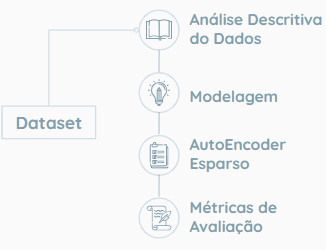

## Banco de dados

- Chemical Composition of Ceramic Samples

- 17 variáveis

- 88 amostras

- 2 Clases (Body e Glaze)


Link do dataset - https://archive.ics.uci.edu/dataset/583/chemical+composition+of+ceramic+samples

## Pacotes

In [ ]:
# Instalar o lazypredict
!pip install lazypredict

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 59.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 741.4/741.4 kB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.6/201.6 kB 12.5 MB/s eta 0:00:00


In [ ]:
# Inserir os bancos do python:
#Manipulação de dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import shapiro, anderson
#Modelagem
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, cross_validate
from lazypredict.Supervised import LazyClassifier
# Escolhendo o modelo (1) e as metricas de avaliação
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
#Escolhendo o modelo (2)
from sklearn.ensemble import RandomForestClassifier
#Modelo autoencoder
from sklearn.neighbors import KNeighborsClassifier
#Autoencoder
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import regularizers
import os
import random

## Inserir o dataset

O dataset deve ser carregado no servidor do colab.

In [ ]:
# Inserir o banco de dados
dataceramica = "/content/Chemical Composion of Ceramic.csv"
dataset = pd.read_csv(dataceramica)

In [ ]:
# Visualizar as primeiras linhas do banco de dados
print(dataset.head())

  Ceramic Name  Part  Na2O  MgO  Al2O3  SiO2  K2O  CaO  TiO2  Fe2O3  MnO  CuO  \
0      FLQ-1-b  Body  0.62 0.38  19.61 71.99 4.84 0.31  0.07   1.18  630   10   
1      FLQ-2-b  Body  0.57 0.47  21.19 70.09 4.98 0.49  0.09   1.12  380   20   
2      FLQ-3-b  Body  0.49 0.19  18.60 74.70 3.47 0.43  0.06   1.07  420   20   
3      FLQ-4-b  Body  0.89 0.30  18.01 74.19 4.01 0.27  0.09   1.23  460   20   
4      FLQ-5-b  Body  0.03 0.36  18.41 73.99 4.33 0.65  0.05   1.19  380   40   

   ZnO  PbO2  Rb2O  SrO  Y2O3  ZrO2  P2O5  
0   70    10   430    0    40    80    90  
1   80    40   430  -10    40   100   110  
2   50    50   380   40    40    80   200  
3   70    60   380   10    40    70   210  
4   90    40   360   10    30    80   150  


## Análise Descritiva dos Dados

In [ ]:
# Transformar %m/m para ppm, são as colunas 3 até 10
dataset.iloc[:, 2:10] = dataset.iloc[:, 2:10] * 10_000

# Exibir o resultado
print("Dataset atualizado:")
print(dataset.head())

Dataset atualizado:
  Ceramic Name  Part    Na2O     MgO     Al2O3      SiO2      K2O     CaO  \
0      FLQ-1-b  Body 6200.00 3800.00 196100.00 719900.00 48400.00 3100.00   
1      FLQ-2-b  Body 5700.00 4700.00 211900.00 700900.00 49800.00 4900.00   
2      FLQ-3-b  Body 4900.00 1900.00 186000.00 747000.00 34700.00 4300.00   
3      FLQ-4-b  Body 8900.00 3000.00 180100.00 741900.00 40100.00 2700.00   
4      FLQ-5-b  Body  300.00 3600.00 184100.00 739900.00 43300.00 6500.00   

    TiO2    Fe2O3  MnO  CuO  ZnO  PbO2  Rb2O  SrO  Y2O3  ZrO2  P2O5  
0 700.00 11800.00  630   10   70    10   430    0    40    80    90  
1 900.00 11200.00  380   20   80    40   430  -10    40   100   110  
2 600.00 10700.00  420   20   50    50   380   40    40    80   200  
3 900.00 12300.00  460   20   70    60   380   10    40    70   210  
4 500.00 11900.00  380   40   90    40   360   10    30    80   150  


In [ ]:
# Transforma todos os valores negativos em positivos
dataset = dataset.applymap(lambda x: abs(x) if isinstance(x, (int, float)) else x)

# Verificando se ainda há valores negativos
negativos_restantes = (dataset.select_dtypes(include=[np.number]) < 0).sum().sum()
print(f"Total de valores negativos restantes: {negativos_restantes}")

Total de valores negativos restantes: 0


As classes já estão balanceadas, são 44 amostras de body e 44 de glaze

In [ ]:
# Estatística descritiva
# Selecionar apenas colunas numéricas
cn = dataset.select_dtypes(include=['number'])

# Verificar presença de valores NaN
na_counts = cn.isna().sum()
na_columns = na_counts[na_counts > 0]

if not na_columns.empty:
    print("\n⚠️ Valores ausentes encontrados nas seguintes colunas:")
    print(na_columns)

    print("\n📍 Localização dos NaNs:")
    for col in na_columns.index:
        print(f"- {col}: índices com NaN → {cn[cn[col].isna()].index.tolist()}")
else:
    print("\n✅ Nenhum valor NaN encontrado nas colunas numéricas.")

# Calcular estatísticas
media = cn.mean()
mediana = cn.median()
moda = cn.mode().iloc[0]  # Pega a primeira moda encontrada para cada coluna

# Exibir resultados
print("\n📊 Média de cada coluna:")
print(media)

print("\n📊 Mediana de cada coluna:")
print(mediana)

print("\n📊 Moda de cada coluna:")
print(moda)


✅ Nenhum valor NaN encontrado nas colunas numéricas.

📊 Média de cada coluna:
Na2O      4717.05
MgO       4301.14
Al2O3   174609.09
SiO2    698251.14
K2O      49784.09
CaO      41718.18
TiO2      1012.50
Fe2O3    15615.91
MnO        818.75
CuO         30.91
ZnO         95.34
PbO2        38.52
Rb2O       310.45
SrO        229.09
Y2O3        42.95
ZrO2       145.45
P2O5       440.91
dtype: float64

📊 Mediana de cada coluna:
Na2O      3750.00
MgO       4050.00
Al2O3   162050.00
SiO2    699900.00
K2O      50650.00
CaO      26900.00
TiO2       800.00
Fe2O3    15100.00
MnO        590.00
CuO         30.00
ZnO         90.00
PbO2        30.00
Rb2O       320.00
SrO         75.00
Y2O3        40.00
ZrO2       140.00
P2O5       365.00
dtype: float64

📊 Moda de cada coluna:
Na2O       300.00
MgO       4700.00
Al2O3   123700.00
SiO2    663100.00
K2O      34700.00
CaO       1300.00
TiO2       700.00
Fe2O3    11800.00
MnO        420.00
CuO         20.00
ZnO         90.00
PbO2        20.00
Rb2O       3

### Boxplot

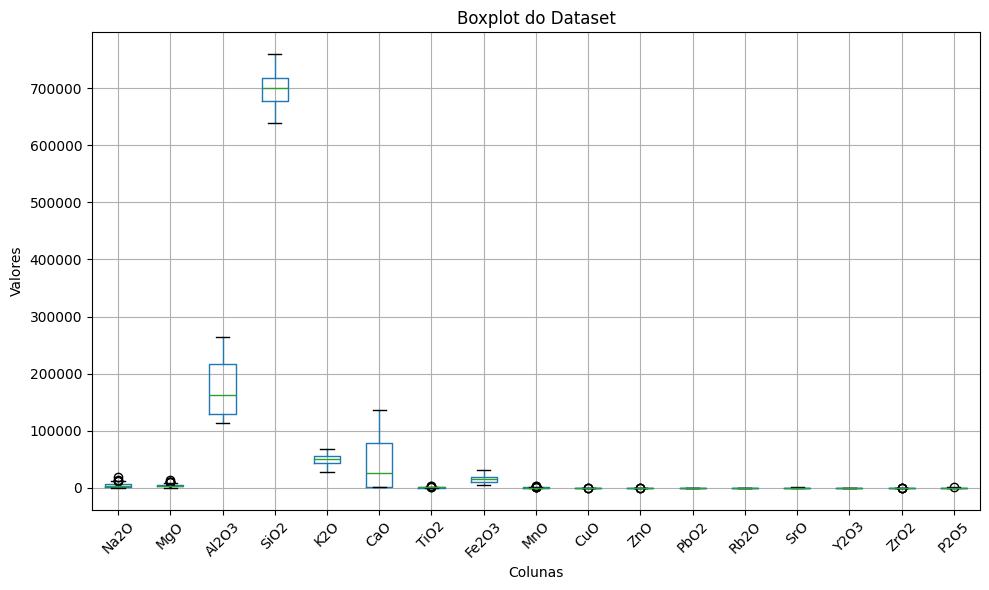

In [ ]:
# Gerar boxplot para visualizar a distribuição e possíveis outliers
plt.figure(figsize=(10, 6))
cn.boxplot()
plt.title("Boxplot do Dataset")
plt.xlabel("Colunas")
plt.ylabel("Valores")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

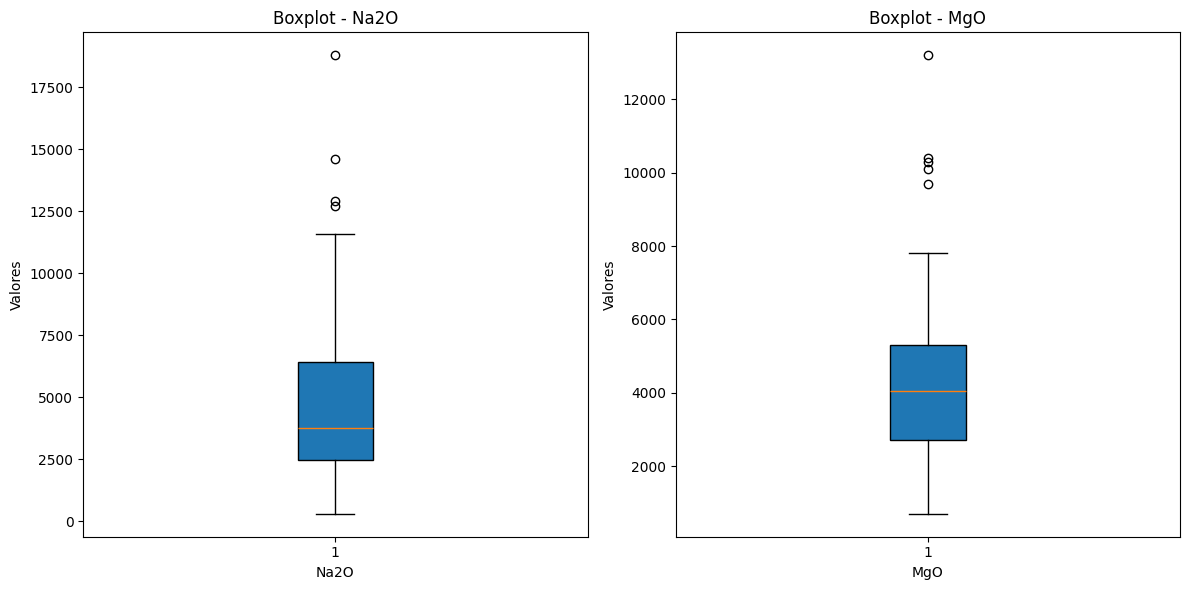

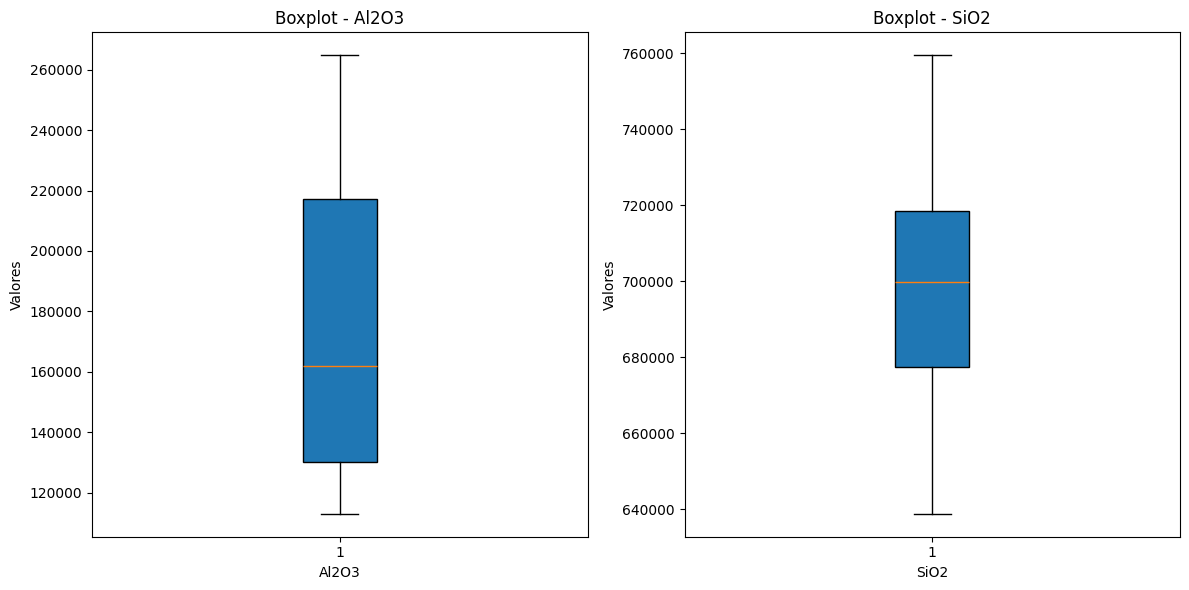

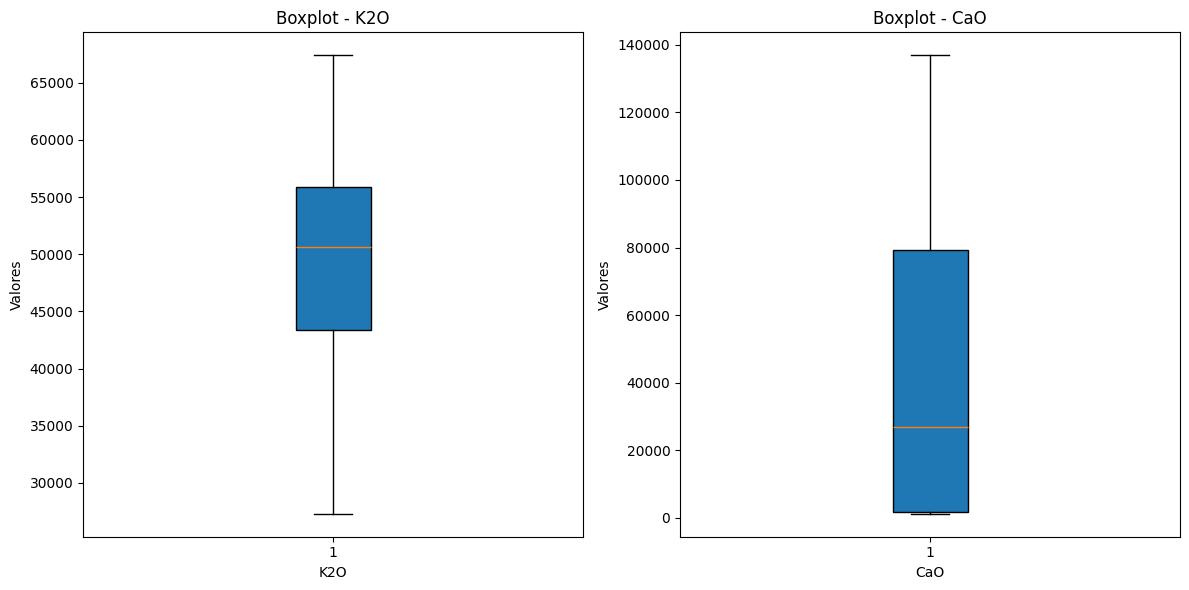

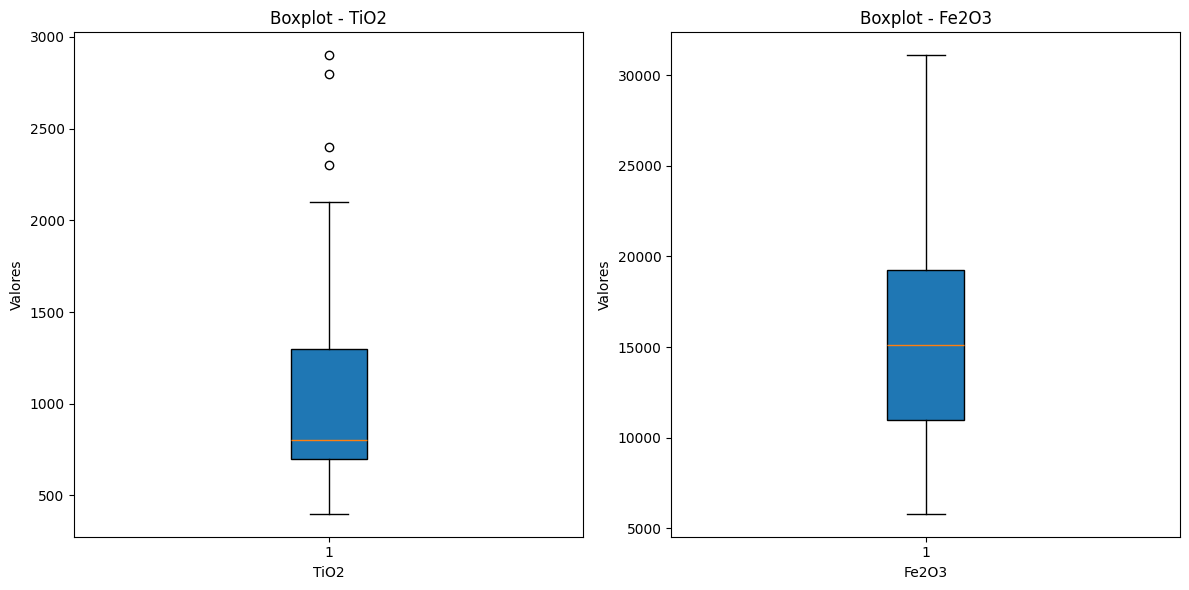

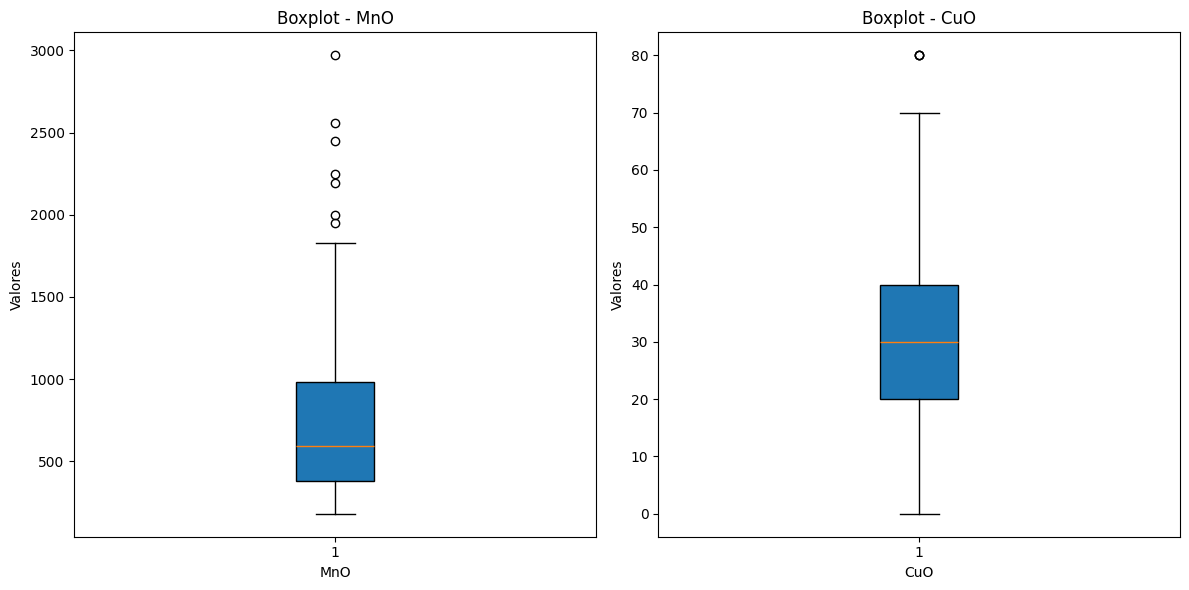

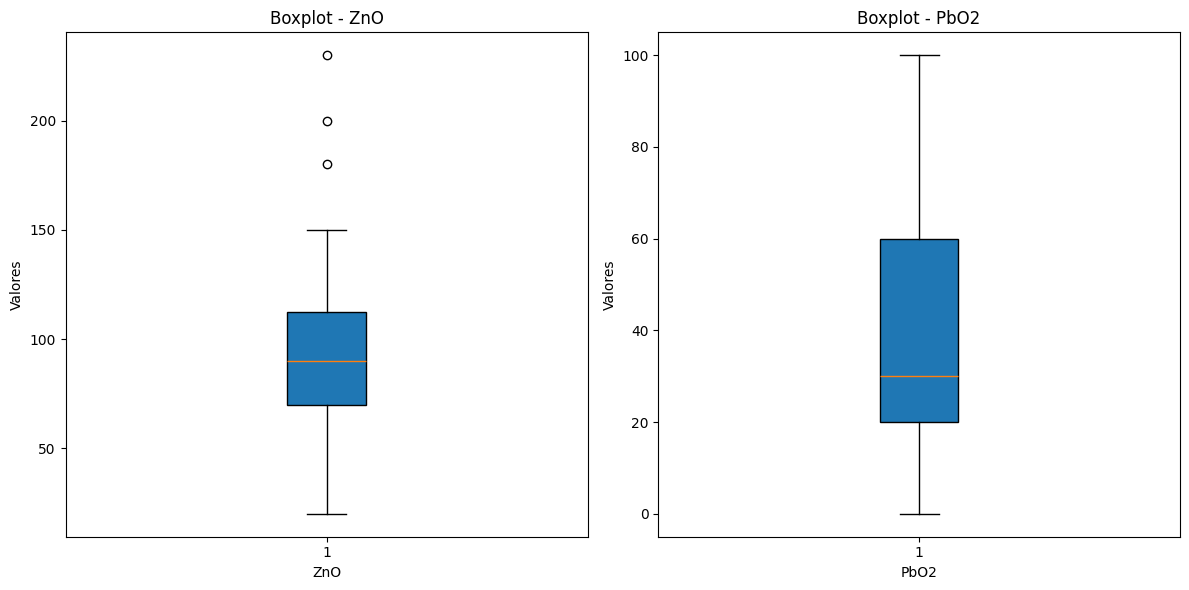

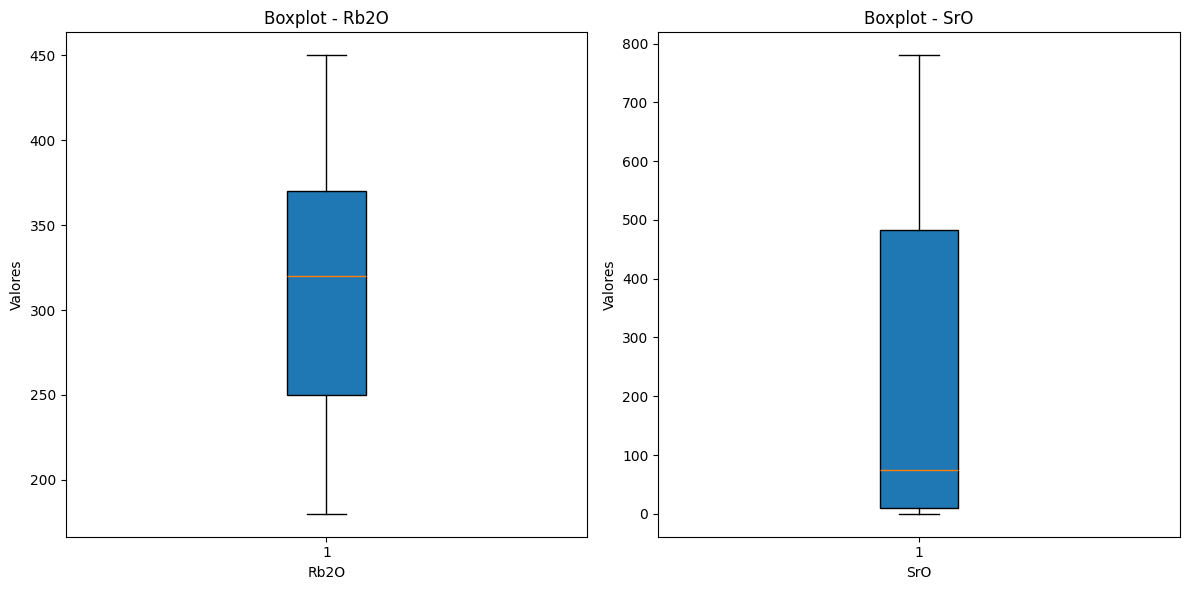

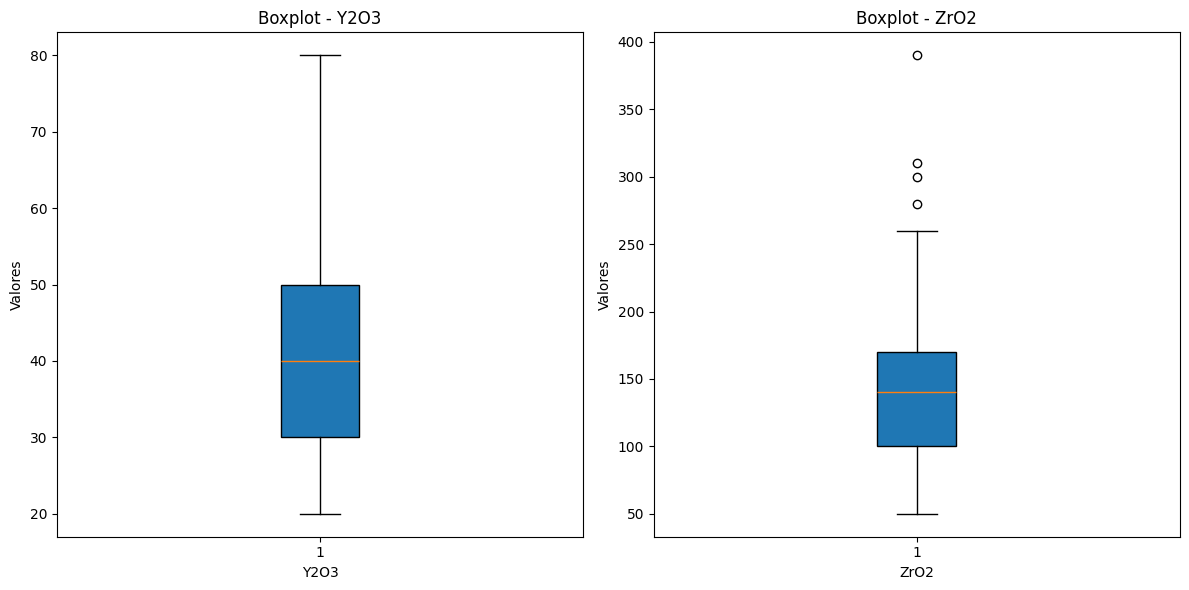

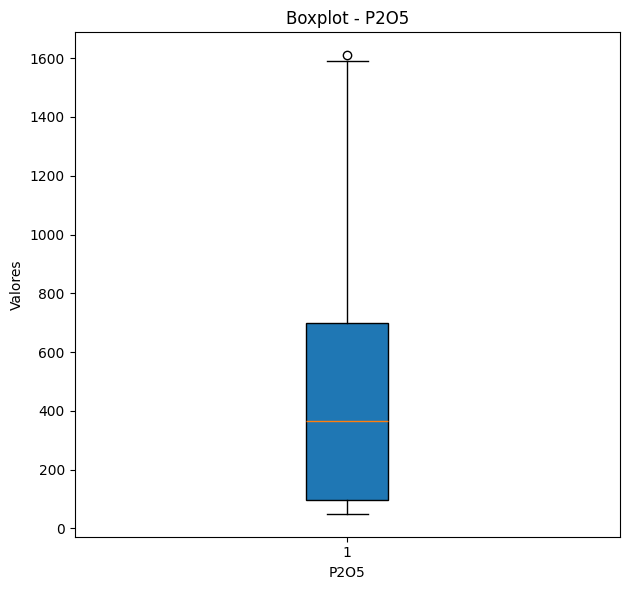

In [ ]:
# Gerar boxplots em pares para economizar espaço
colunas = cn.columns
num_colunas = len(colunas)

# Iterar sobre as colunas em pares
for i in range(0, num_colunas, 2):
    # Configurar o subplot para 2 gráficos lado a lado
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Primeiro boxplot
    axes[0].boxplot(cn[colunas[i]].dropna(), vert=True, patch_artist=True)
    axes[0].set_title(f"Boxplot - {colunas[i]}")
    axes[0].set_xlabel(colunas[i])
    axes[0].set_ylabel("Valores")

    # Segundo boxplot (se existir)
    if i + 1 < num_colunas:
        axes[1].boxplot(cn[colunas[i + 1]].dropna(), vert=True, patch_artist=True)
        axes[1].set_title(f"Boxplot - {colunas[i + 1]}")
        axes[1].set_xlabel(colunas[i + 1])
        axes[1].set_ylabel("Valores")
    else:
        # Remover o segundo subplot se não houver uma segunda coluna
        fig.delaxes(axes[1])

    # Ajustar o layout
    plt.tight_layout()
    plt.show()

In [ ]:
# Inicializar dicionários para guardar os resultados
outliers_info = []

# Iterar sobre as colunas numéricas
for col in cn.select_dtypes(include='number').columns:
    # Remover valores nulos
    data = cn[col].dropna()

    # Calcular Q1, Q3 e IQR
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    # Identificar os outliers
    outliers = data[(data < limite_inferior) | (data > limite_superior)]
    total = len(data)
    qtd_outliers = len(outliers)
    perc_outliers = (qtd_outliers / total) * 100

    # Armazenar os resultados
    outliers_info.append({
        "Variável": col,
        "Outliers": qtd_outliers,
        "Porcentagem de outliers (%)": round(perc_outliers, 2)
    })

# Criar DataFrame com os resultados
df_outliers = pd.DataFrame(outliers_info)

# Exibir a tabela
print(df_outliers)

   Variável  Outliers  Porcentagem de outliers (%)
0      Na2O         4                         4.55
1       MgO         5                         5.68
2     Al2O3         0                         0.00
3      SiO2         0                         0.00
4       K2O         0                         0.00
5       CaO         0                         0.00
6      TiO2         4                         4.55
7     Fe2O3         0                         0.00
8       MnO         7                         7.95
9       CuO         3                         3.41
10      ZnO         3                         3.41
11     PbO2         0                         0.00
12     Rb2O         0                         0.00
13      SrO         0                         0.00
14     Y2O3         0                         0.00
15     ZrO2         4                         4.55
16     P2O5         1                         1.14


### Histograma

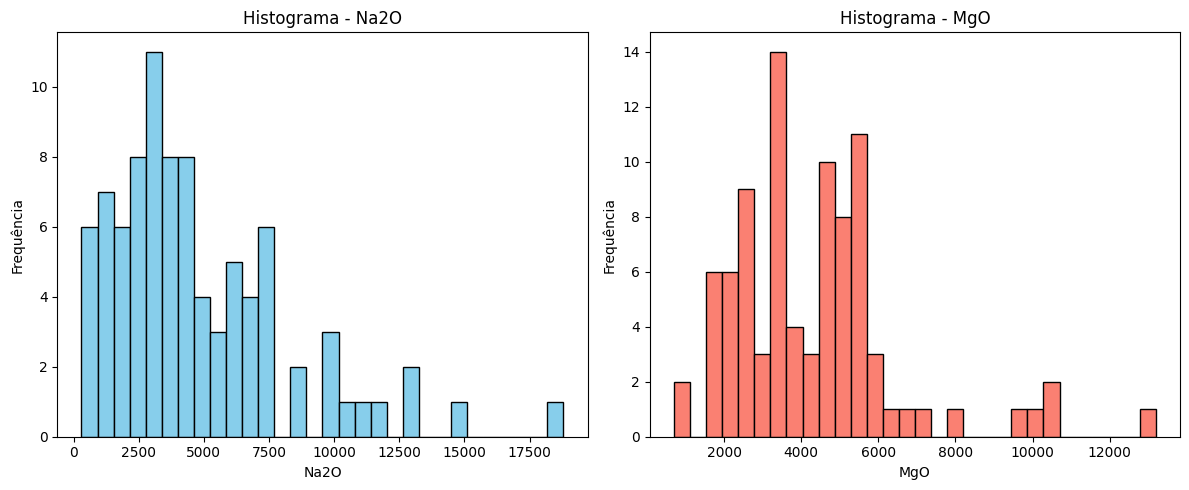

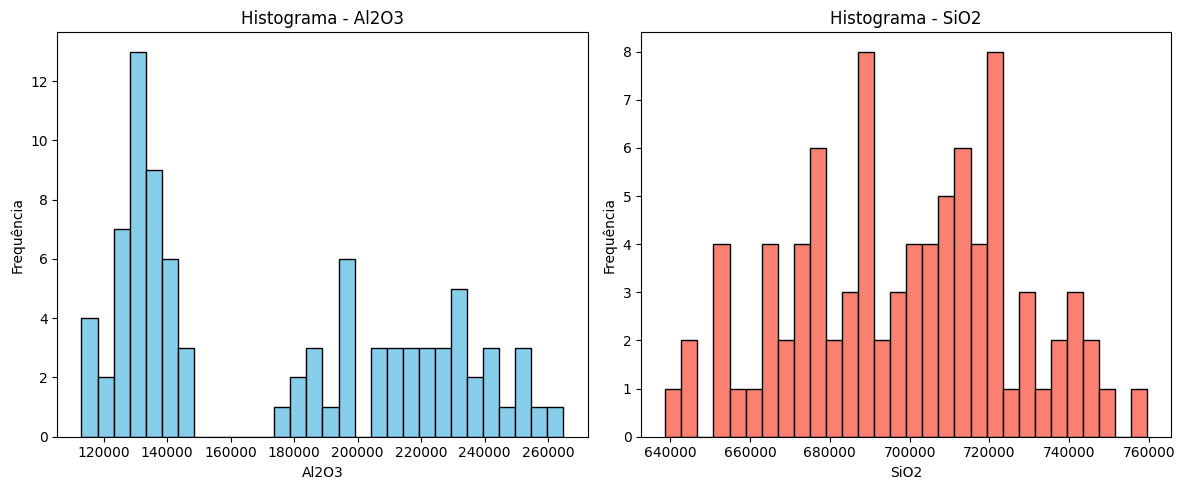

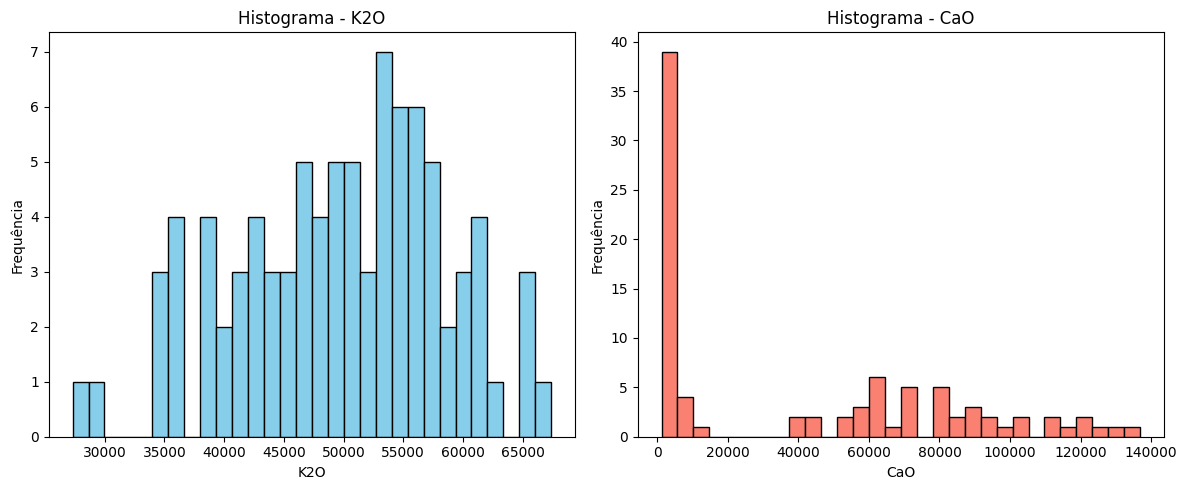

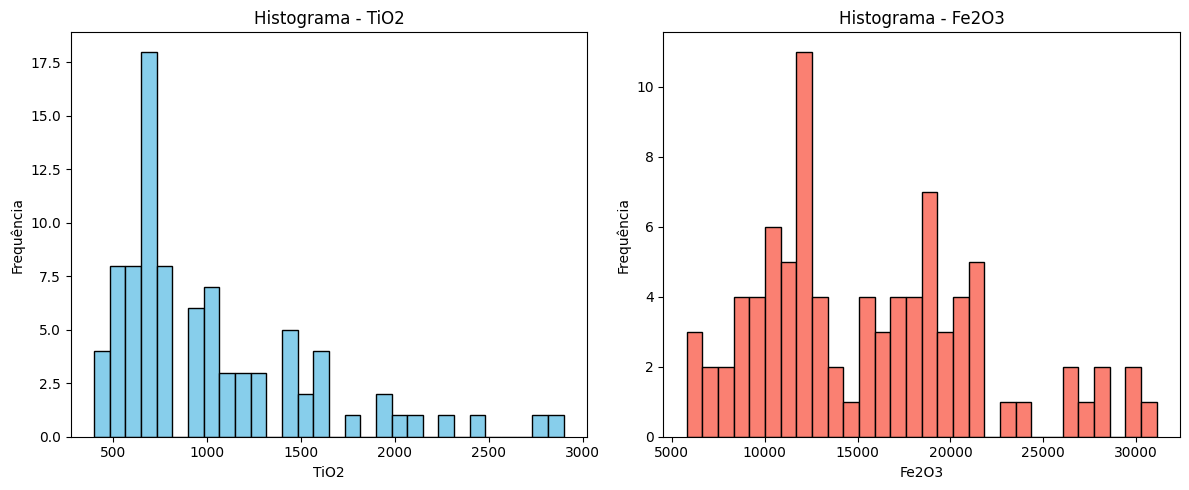

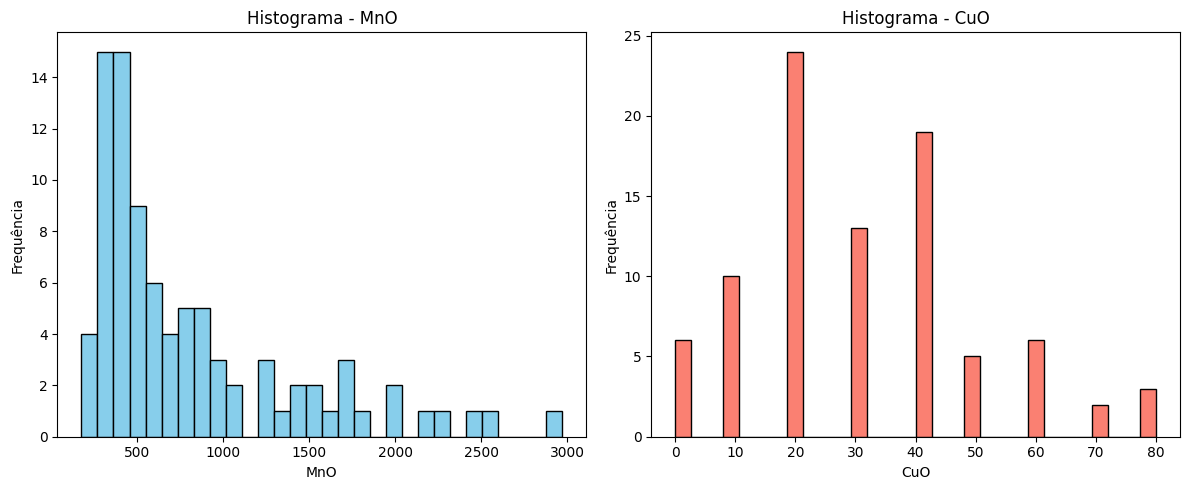

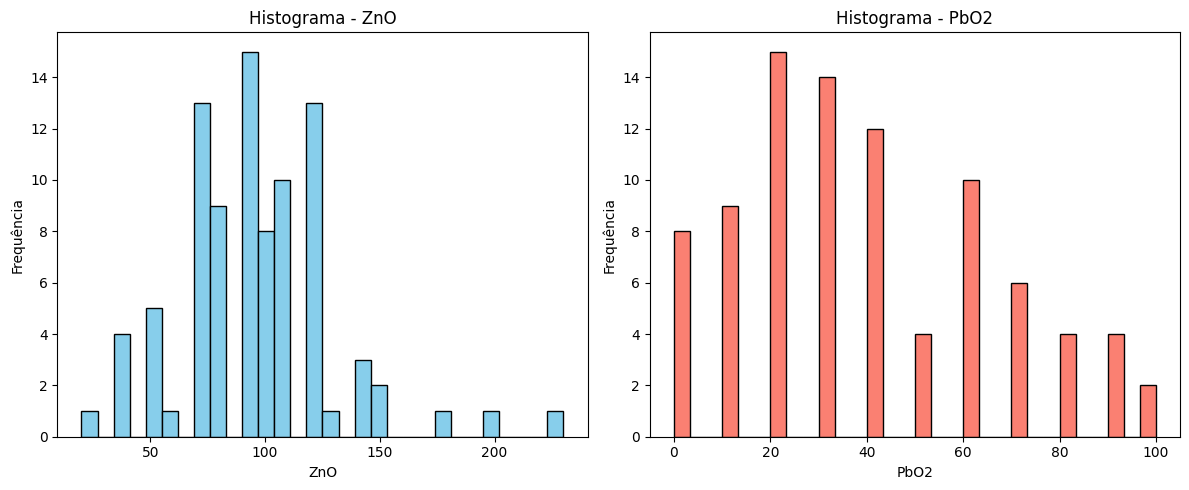

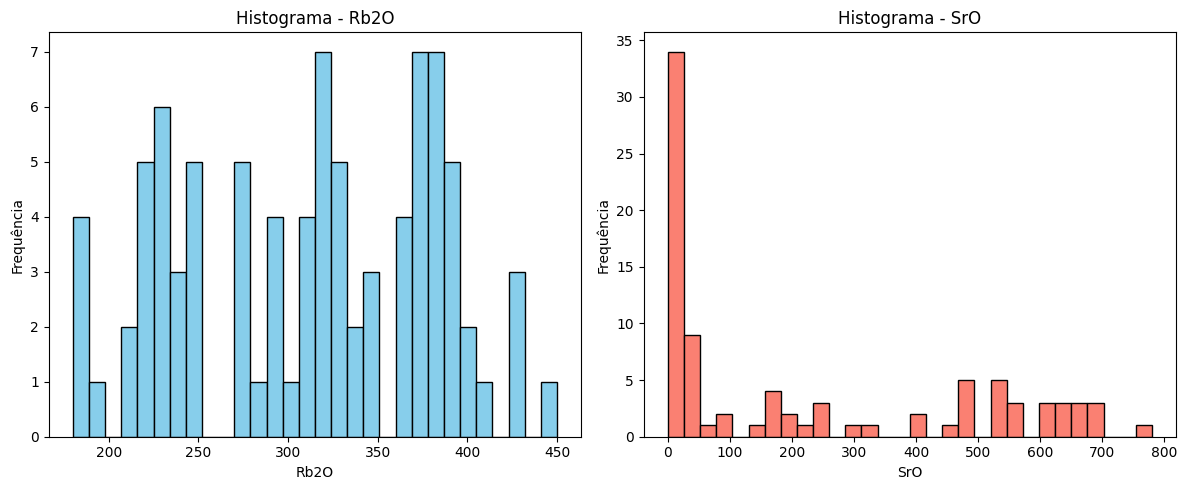

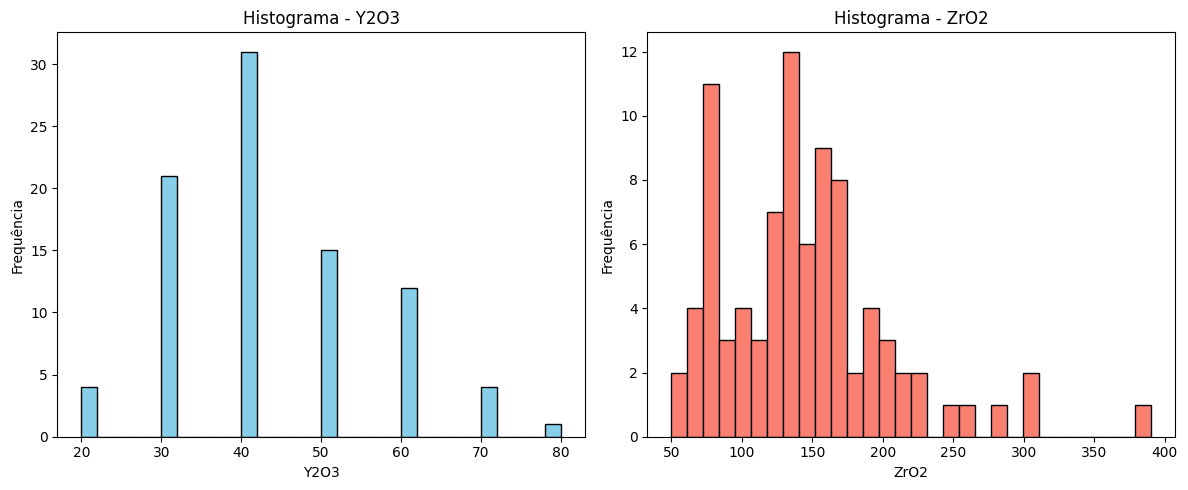

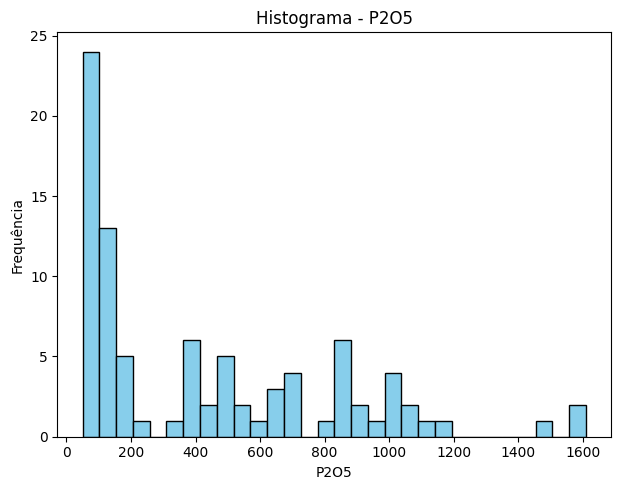

In [ ]:
# Iterar sobre as colunas em pares
for i in range(0, num_colunas, 2):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Primeiro histograma
    axes[0].hist(cn[colunas[i]].dropna(), bins=30, color='skyblue', edgecolor='black')
    axes[0].set_title(f"Histograma - {colunas[i]}")
    axes[0].set_xlabel(colunas[i])
    axes[0].set_ylabel("Frequência")

    # Segundo histograma (se houver)
    if i + 1 < num_colunas:
        axes[1].hist(cn[colunas[i + 1]].dropna(), bins=30, color='salmon', edgecolor='black')
        axes[1].set_title(f"Histograma - {colunas[i + 1]}")
        axes[1].set_xlabel(colunas[i + 1])
        axes[1].set_ylabel("Frequência")
    else:
        fig.delaxes(axes[1])  # Remove o eixo extra se não houver segunda coluna

    plt.tight_layout()
    plt.show()

### Shapiro-Wilk e Anderson-Darling

In [ ]:
# Armazenar os resultados
resultados = []

# Iterar sobre colunas numéricas
for col in cn.select_dtypes(include='number').columns:
    data = cn[col].dropna()

    # Teste de Shapiro-Wilk (n < 5000 recomendado)
    stat_shapiro, p_shapiro = shapiro(data)
    normal_shapiro = 'Sim' if p_shapiro > 0.05 else 'Não'

    # Teste de Anderson-Darling
    result_anderson = anderson(data, dist='norm')
    stat_anderson = result_anderson.statistic
    crit_values = result_anderson.critical_values
    significance = result_anderson.significance_level

    # Verifica se a estatística está abaixo do valor crítico a 5%
    lim_critico_5 = crit_values[significance.tolist().index(5.0)]
    normal_anderson = 'Sim' if stat_anderson < lim_critico_5 else 'Não'

    # Armazenar resultados
    resultados.append({
        'Variável': col,
        'Shapiro-Wilk (p-valor)': round(p_shapiro, 4),
        'Normal (Shapiro)?': normal_shapiro,
        'Anderson-Darling (estatística)': round(stat_anderson, 4),
        'Crítico 5%': round(lim_critico_5, 4),
        'Normal (Anderson)?': normal_anderson
    })

# Criar DataFrame com os resultados
df_normalidade = pd.DataFrame(resultados)

# Exibir os resultados
print(df_normalidade)

   Variável  Shapiro-Wilk (p-valor) Normal (Shapiro)?  \
0      Na2O                    0.00               Não   
1       MgO                    0.00               Não   
2     Al2O3                    0.00               Não   
3      SiO2                    0.53               Sim   
4       K2O                    0.46               Sim   
5       CaO                    0.00               Não   
6      TiO2                    0.00               Não   
7     Fe2O3                    0.00               Não   
8       MnO                    0.00               Não   
9       CuO                    0.00               Não   
10      ZnO                    0.00               Não   
11     PbO2                    0.00               Não   
12     Rb2O                    0.01               Não   
13      SrO                    0.00               Não   
14     Y2O3                    0.00               Não   
15     ZrO2                    0.00               Não   
16     P2O5                    

### Mapa de Correlação

**Spearman**:

- Dados não lineares e não se preocupa com a distribuição normal dos dados e quando contém outliers


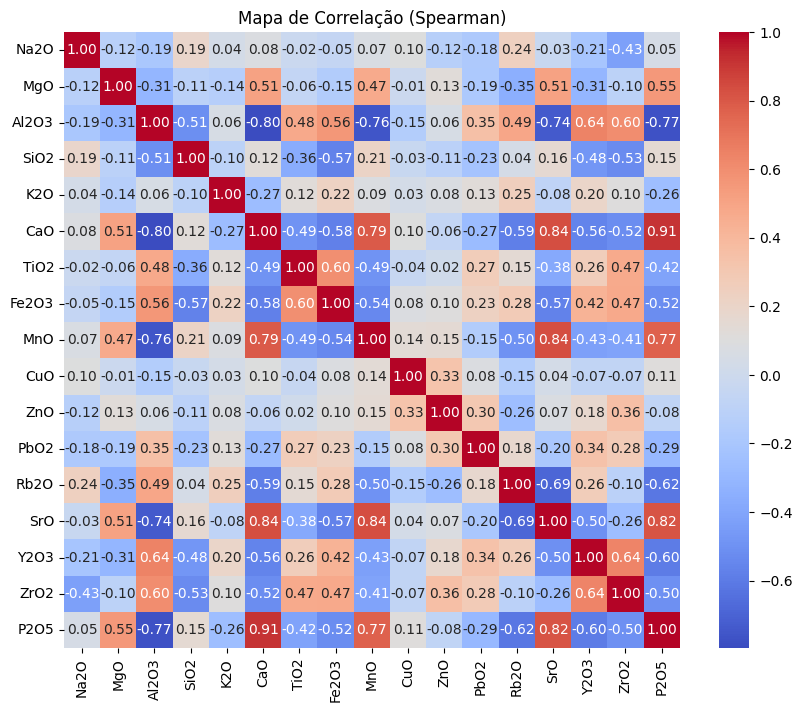

In [ ]:
# Mapa de correlação de Sperman
# Calcular a matriz de correlação (coeficiente de Spearman)
correlacao_spearman = cn.corr(method='spearman')

# Gerar o mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(correlacao_spearman, annot=True, cmap="coolwarm", fmt=".2f", cbar=True, square=True)
plt.title("Mapa de Correlação (Spearman)")
plt.show()

In [ ]:
# Função para selecionar pares de variáveis com correlação maior que 0.7 (em valor absoluto)
def selecionar_variaveis_correlacao(correlacao, metodo):
    correlacao_forte = []
    for i in range(len(correlacao.columns)):
        for j in range(i + 1, len(correlacao.columns)):
            if abs(correlacao.iloc[i, j]) > 0.7:  # Critério de correlação > 0.7
                correlacao_forte.append((correlacao.index[i], correlacao.columns[j], correlacao.iloc[i, j]))
    return pd.DataFrame(correlacao_forte, columns=["Variável 1", "Variável 2", f"Correlação ({metodo})"])

# Selecionar pares de variáveis com correlação forte
correlacao_forte_spearman = selecionar_variaveis_correlacao(correlacao_spearman, "Spearman")

# Exibir os resultados
print("\nPares de variáveis com correlação forte (Spearman):")
print(correlacao_forte_spearman)


Pares de variáveis com correlação forte (Spearman):
  Variável 1 Variável 2  Correlação (Spearman)
0      Al2O3        CaO                  -0.80
1      Al2O3        MnO                  -0.76
2      Al2O3        SrO                  -0.74
3      Al2O3       P2O5                  -0.77
4        CaO        MnO                   0.79
5        CaO        SrO                   0.84
6        CaO       P2O5                   0.91
7        MnO        SrO                   0.84
8        MnO       P2O5                   0.77
9        SrO       P2O5                   0.82


Transformar variavél categórica alvo em variável binária

**Body** - 0

**Glaze** - 1

In [ ]:
# Substituir "Body" por 0 e "Glaze" por 1 apenas na coluna 'Part'
df = dataset.copy()
df['Part'] = df['Part'].replace({'Body': 0, 'Glaze': 1})

# Verificar o resultado
print(df.head())


  Ceramic Name  Part    Na2O     MgO     Al2O3      SiO2      K2O     CaO  \
0      FLQ-1-b     0 6200.00 3800.00 196100.00 719900.00 48400.00 3100.00   
1      FLQ-2-b     0 5700.00 4700.00 211900.00 700900.00 49800.00 4900.00   
2      FLQ-3-b     0 4900.00 1900.00 186000.00 747000.00 34700.00 4300.00   
3      FLQ-4-b     0 8900.00 3000.00 180100.00 741900.00 40100.00 2700.00   
4      FLQ-5-b     0  300.00 3600.00 184100.00 739900.00 43300.00 6500.00   

    TiO2    Fe2O3  MnO  CuO  ZnO  PbO2  Rb2O  SrO  Y2O3  ZrO2  P2O5  
0 700.00 11800.00  630   10   70    10   430    0    40    80    90  
1 900.00 11200.00  380   20   80    40   430   10    40   100   110  
2 600.00 10700.00  420   20   50    50   380   40    40    80   200  
3 900.00 12300.00  460   20   70    60   380   10    40    70   210  
4 500.00 11900.00  380   40   90    40   360   10    30    80   150  


In [ ]:
#Removendo a coluna Ceramic Name
df.drop(columns=['Ceramic Name'], inplace=True)
print(df.head())

   Part    Na2O     MgO     Al2O3      SiO2      K2O     CaO   TiO2    Fe2O3  \
0     0 6200.00 3800.00 196100.00 719900.00 48400.00 3100.00 700.00 11800.00   
1     0 5700.00 4700.00 211900.00 700900.00 49800.00 4900.00 900.00 11200.00   
2     0 4900.00 1900.00 186000.00 747000.00 34700.00 4300.00 600.00 10700.00   
3     0 8900.00 3000.00 180100.00 741900.00 40100.00 2700.00 900.00 12300.00   
4     0  300.00 3600.00 184100.00 739900.00 43300.00 6500.00 500.00 11900.00   

   MnO  CuO  ZnO  PbO2  Rb2O  SrO  Y2O3  ZrO2  P2O5  
0  630   10   70    10   430    0    40    80    90  
1  380   20   80    40   430   10    40   100   110  
2  420   20   50    50   380   40    40    80   200  
3  460   20   70    60   380   10    40    70   210  
4  380   40   90    40   360   10    30    80   150  


## Separação das variáveis teste e treino

80% treino

20% teste

variável alvo - body ou glaze (part)

In [ ]:
# Normalização
# Selecionar apenas as colunas numéricas para normalização
colunas_numericas = df.select_dtypes(include=['number'])

# Aplicar a normalização Min-Max
scaler = MinMaxScaler()
dados_normalizados = scaler.fit_transform(colunas_numericas)

# Criar um novo DataFrame com os dados normalizados
df_normalizado = pd.DataFrame(dados_normalizados, columns=colunas_numericas.columns)

# Exibir os dados normalizados
print(df_normalizado.head())

# Adicionar colunas categóricas de volta, se necessário
#colunas_categoricas = df.select_dtypes(exclude=['number'])
#df_final = pd.concat([df_normalizado, colunas_categoricas.reset_index(drop=True)], axis=1)

   Part  Na2O  MgO  Al2O3  SiO2  K2O  CaO  TiO2  Fe2O3  MnO  CuO  ZnO  PbO2  \
0  0.00  0.32 0.25   0.55  0.67 0.53 0.01  0.12   0.24 0.16 0.12 0.24  0.10   
1  0.00  0.29 0.32   0.65  0.51 0.56 0.03  0.20   0.21 0.07 0.25 0.29  0.40   
2  0.00  0.25 0.10   0.48  0.90 0.18 0.02  0.08   0.19 0.09 0.25 0.14  0.50   
3  0.00  0.46 0.18   0.44  0.85 0.32 0.01  0.20   0.26 0.10 0.25 0.24  0.60   
4  0.00  0.00 0.23   0.47  0.84 0.40 0.04  0.04   0.24 0.07 0.50 0.33  0.40   

   Rb2O  SrO  Y2O3  ZrO2  P2O5  
0  0.93 0.00  0.33  0.09  0.03  
1  0.93 0.01  0.33  0.15  0.04  
2  0.74 0.05  0.33  0.09  0.10  
3  0.74 0.01  0.33  0.06  0.10  
4  0.67 0.01  0.17  0.09  0.06  


In [ ]:
# Separar as variáveis independentes (X) e dependente (y)
X = df_normalizado.drop(columns=['Part'])  # Variáveis preditoras
y = df_normalizado['Part']                 # Variável alvo

# Dividir o dataset em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42  # 20% para teste
)

# Exibir os tamanhos dos conjuntos
print(f"Tamanho do conjunto de treino: {X_train.shape[0]} linhas")
print(f"Tamanho do conjunto de teste: {X_test.shape[0]} linhas")

Tamanho do conjunto de treino: 70 linhas
Tamanho do conjunto de teste: 18 linhas


Pela quantidade de amostras e variáveis não haverá redução de dimensionalidade e nem exclusão de variáveis com alta correlação e nem exclusão de outliers.

## Modelagem

In [ ]:
# Inicializar o LazyClassifier
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)

# Ajustar e comparar modelos
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

# Exibir os resultados
print(models)


  0%|          | 0/32 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 34, number of negative: 36
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314
[LightGBM] [Info] Number of data points in the train set: 70, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.485714 -> initscore=-0.057158
[LightGBM] [Info] Start training from score -0.057158
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

In [ ]:
# Exibir os top 5 modelos
print(models.head(9))

                        Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                    
AdaBoostClassifier          1.00               1.00     1.00      1.00   
BaggingClassifier           1.00               1.00     1.00      1.00   
BernoulliNB                 1.00               1.00     1.00      1.00   
CalibratedClassifierCV      1.00               1.00     1.00      1.00   
DecisionTreeClassifier      1.00               1.00     1.00      1.00   
ExtraTreeClassifier         1.00               1.00     1.00      1.00   
ExtraTreesClassifier        1.00               1.00     1.00      1.00   
KNeighborsClassifier        1.00               1.00     1.00      1.00   
GaussianNB                  1.00               1.00     1.00      1.00   

                        Time Taken  
Model                               
AdaBoostClassifier            0.08  
BaggingClassifier             0.10  
BernoulliNB                   0.03  


### AdaBoostClassifier

In [ ]:
# Inicializar e treinar o AdaBoostClassifier
model = AdaBoostClassifier(n_estimators=25, random_state=42)  # Ajuste n_estimators conforme necessário
model.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred = model.predict(X_test)

In [ ]:
# Relatório de classificação detalhado
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         8
         1.0       1.00      1.00      1.00        10

    accuracy                           1.00        18
   macro avg       1.00      1.00      1.00        18
weighted avg       1.00      1.00      1.00        18



In [ ]:
# Matriz de confusão
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Confusion Matrix:
 [[ 8  0]
 [ 0 10]]


### Permutando o conjunto de teste

Body - 1
Glaze - 0

In [ ]:
# Criar uma cópia do dataset
df_permutado = df.copy()

# Inverter os valores apenas na coluna 'Part': 0 vira 1 e 1 vira 0
df_permutado['Part'] = df_permutado['Part'].replace({0: 1, 1: 0})

# Verificar o resultado
print(df_permutado.head())

   Part    Na2O     MgO     Al2O3      SiO2      K2O     CaO   TiO2    Fe2O3  \
0     1 6200.00 3800.00 196100.00 719900.00 48400.00 3100.00 700.00 11800.00   
1     1 5700.00 4700.00 211900.00 700900.00 49800.00 4900.00 900.00 11200.00   
2     1 4900.00 1900.00 186000.00 747000.00 34700.00 4300.00 600.00 10700.00   
3     1 8900.00 3000.00 180100.00 741900.00 40100.00 2700.00 900.00 12300.00   
4     1  300.00 3600.00 184100.00 739900.00 43300.00 6500.00 500.00 11900.00   

   MnO  CuO  ZnO  PbO2  Rb2O  SrO  Y2O3  ZrO2  P2O5  
0  630   10   70    10   430    0    40    80    90  
1  380   20   80    40   430   10    40   100   110  
2  420   20   50    50   380   40    40    80   200  
3  460   20   70    60   380   10    40    70   210  
4  380   40   90    40   360   10    30    80   150  


In [ ]:
# Normalização
# Selecionar apenas as colunas numéricas para normalização
colunas_numericas_per = df_permutado.select_dtypes(include=['number'])

# Aplicar a normalização Min-Max
scaler = MinMaxScaler()
dados_normalizados_per = scaler.fit_transform(colunas_numericas_per)

# Criar um novo DataFrame com os dados normalizados
df_normalizado_per = pd.DataFrame(dados_normalizados_per, columns=colunas_numericas_per.columns)

# Exibir os dados normalizados
print(df_normalizado_per.head())

# Adicionar colunas categóricas de volta, se necessário
#colunas_categoricas_per = df_permutado.select_dtypes(exclude=['number'])
#df_final_per = pd.concat([df_normalizado_per, colunas_categoricas_per.reset_index(drop=True)], axis=1)

   Part  Na2O  MgO  Al2O3  SiO2  K2O  CaO  TiO2  Fe2O3  MnO  CuO  ZnO  PbO2  \
0  1.00  0.32 0.25   0.55  0.67 0.53 0.01  0.12   0.24 0.16 0.12 0.24  0.10   
1  1.00  0.29 0.32   0.65  0.51 0.56 0.03  0.20   0.21 0.07 0.25 0.29  0.40   
2  1.00  0.25 0.10   0.48  0.90 0.18 0.02  0.08   0.19 0.09 0.25 0.14  0.50   
3  1.00  0.46 0.18   0.44  0.85 0.32 0.01  0.20   0.26 0.10 0.25 0.24  0.60   
4  1.00  0.00 0.23   0.47  0.84 0.40 0.04  0.04   0.24 0.07 0.50 0.33  0.40   

   Rb2O  SrO  Y2O3  ZrO2  P2O5  
0  0.93 0.00  0.33  0.09  0.03  
1  0.93 0.01  0.33  0.15  0.04  
2  0.74 0.05  0.33  0.09  0.10  
3  0.74 0.01  0.33  0.06  0.10  
4  0.67 0.01  0.17  0.09  0.06  


In [ ]:
# Separar as variáveis independentes (X) e dependente (y)
y_per = df_normalizado_per['Part']                 # Variável alvo

# Dividir o dataset em treino e teste
X_train, X_test, y_train_per, y_test_per = train_test_split(
    X, y_per, test_size=0.2, random_state=42  # 20% para teste
)

# Exibir os tamanhos dos conjuntos
print(f"Tamanho do conjunto de treino: {X_train.shape[0]} linhas")
print(f"Tamanho do conjunto de teste: {X_test.shape[0]} linhas")

Tamanho do conjunto de treino: 70 linhas
Tamanho do conjunto de teste: 18 linhas


In [ ]:
# Inicializar e treinar o AdaBoostClassifier
model = AdaBoostClassifier(n_estimators=25, random_state=42)  # Ajuste n_estimators conforme necessário
model.fit(X_train, y_train_per)

# Fazer previsões no conjunto de teste
y_pred_per = model.predict(X_test)

In [ ]:
# Relatório de classificação detalhado
print("\nClassification Report:\n", classification_report(y_test_per, y_pred_per))


Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        10
         1.0       1.00      1.00      1.00         8

    accuracy                           1.00        18
   macro avg       1.00      1.00      1.00        18
weighted avg       1.00      1.00      1.00        18



In [ ]:
# Matriz de confusão
print("\nConfusion Matrix:\n", confusion_matrix(y_test_per, y_pred_per))


Confusion Matrix:
 [[10  0]
 [ 0  8]]


###Random Forest

Mais robusto e menos sujeito a overfitting

In [ ]:
# Ajuste do modelo com hiperparâmetros ajustados
model_2 = RandomForestClassifier(
    n_estimators=15,  # Reduzir o número de árvores
    max_depth=10,     # Limitar a profundidade das árvores
    min_samples_split=10,  # Aumentar o número mínimo de amostras para dividir um nó
    min_samples_leaf=4,    # Aumentar o número mínimo de amostras por folha
    max_features="sqrt",   # Limitar o número de características consideradas
    random_state=42
)

model_2.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred_2 = model_2.predict(X_test)

In [ ]:
# Relatório de classificação detalhado
print("\nClassification Report:\n", classification_report(y_test, y_pred_2))


Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         8
         1.0       1.00      1.00      1.00        10

    accuracy                           1.00        18
   macro avg       1.00      1.00      1.00        18
weighted avg       1.00      1.00      1.00        18



In [ ]:
# Matriz de confusão
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_2))


Confusion Matrix:
 [[ 8  0]
 [ 0 10]]


### Permutação


In [ ]:
# Criar o modelo RandomForestClassifier
model_perm = RandomForestClassifier(
    n_estimators=25,
    random_state=42
)

# Treinar o modelo no conjunto permutado
model_perm.fit(X_train, y_train_per)

# Fazer previsões no conjunto de teste permutado
y_pred_per_2 = model_perm.predict(X_test)

In [ ]:
# Relatório de classificação detalhado
print("\nClassification Report:\n", classification_report(y_test_per, y_pred_per_2))


Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        10
         1.0       1.00      1.00      1.00         8

    accuracy                           1.00        18
   macro avg       1.00      1.00      1.00        18
weighted avg       1.00      1.00      1.00        18



In [ ]:
# Matriz de confusão
print("\nConfusion Matrix:\n", confusion_matrix(y_test_per, y_pred_per_2))


Confusion Matrix:
 [[10  0]
 [ 0  8]]


 O modelo está com um sobreajuste



##Autoencoder

In [ ]:
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'  # força operações determinísticas no TF

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
# Definir a arquitetura do autoencoder esparso
input_dim = X_train.shape[1]  # Número de features
encoding_dim = 10  # Dimensão da camada latente
l1_penalty = 1e-5  # Penalidade L1 para esparsidade (ajustável)

# Camada de entrada
input_layer = Input(shape=(input_dim,))
# Camada de codificação com regularização L1
encoded = Dense(encoding_dim, activation='relu',
                activity_regularizer=regularizers.l1(l1_penalty))(input_layer)
# Camada de decodificação
decoded = Dense(input_dim, activation='sigmoid')(encoded)

# Definir e compilar o autoencoder
autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Treinamento do autoencoder
autoencoder.fit(X_train, X_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test, X_test),
                verbose=1)

# Encoder separado para extrair representações latentes
encoder = Model(input_layer, encoded)
X_train_latent = encoder.predict(X_train)
X_test_latent = encoder.predict(X_test)

# Treinar modelo RandomForest com os dados latentes
model_2 = RandomForestClassifier(n_estimators=15, max_depth=10,
                                 min_samples_split=10, min_samples_leaf=4,
                                 random_state=42)
model_2.fit(X_train_latent, y_train)

# Previsões e acurácia
y_pred_2 = model_2.predict(X_test_latent)
accuracy_2 = accuracy_score(y_test, y_pred_2)
print(f"Acurácia com autoencoder esparso: {accuracy_2:.4f}")



Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.1077 - val_loss: 0.1010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.1071 - val_loss: 0.1003
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.1064 - val_loss: 0.0997
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 786ms/step - loss: 0.1058 - val_loss: 0.0990
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 986ms/step - loss: 0.1052 - val_loss: 0.0983
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step - loss: 0.1046 - val_loss: 0.0977
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step - loss: 0.1040 - val_loss: 0.0970
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step - loss: 0.1034 - val_loss: 0.0964
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - loss: 0.1028 - val_loss: 0.0958
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - loss: 0.1022 - val_loss: 0.0951
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - loss: 0.1016 - val_loss: 0.0945
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - loss: 0.1011 - val_loss: 0.093

In [ ]:
#Novo conjunto de dados
df_latent = pd.DataFrame(X_train_latent)
print("\nExemplo do novo conjunto de dados latentes (treino):")
print(df_latent.head())

print(f"Número de amostras no conjunto latente de treino: {X_train_latent.shape[0]}")
print(f"Número de variáveis (features) latentes: {X_train_latent.shape[1]}")


Exemplo do novo conjunto de dados latentes (treino):
     0    1    2    3    4    5    6    7    8    9
0 0.00 0.18 0.00 0.00 0.35 0.00 0.83 0.00 0.16 0.00
1 0.00 0.78 0.00 0.00 0.00 0.00 0.47 0.00 0.67 0.00
2 0.00 0.09 0.03 0.06 0.27 0.00 0.33 0.00 0.37 0.00
3 0.00 0.74 0.41 0.00 0.14 0.00 0.39 0.00 0.90 0.00
4 0.00 0.58 0.23 0.00 0.25 0.00 0.49 0.00 0.54 0.00
Número de amostras no conjunto latente de treino: 70
Número de variáveis (features) latentes: 10


## Modelagem após autoencoder

In [ ]:
# Criar o LazyClassifier
clf = LazyClassifier(verbose=1, ignore_warnings=True, custom_metric=accuracy_score, random_state=42)

# Treinar e testar modelos nos dados latentes
models, predictions = clf.fit(X_train_latent, X_test_latent, y_train, y_test)

# Exibir os resultados
print("\nResultados do LazyClassifier com representações latentes:")
print(models)

  0%|          | 0/32 [00:00<?, ?it/s]

{'Model': 'AdaBoostClassifier', 'Accuracy': 0.7777777777777778, 'Balanced Accuracy': np.float64(0.75), 'ROC AUC': np.float64(0.75), 'F1 Score': 0.7592592592592593, 'accuracy_score': 0.7777777777777778, 'Time taken': 0.39774107933044434}
{'Model': 'BaggingClassifier', 'Accuracy': 0.7777777777777778, 'Balanced Accuracy': np.float64(0.75), 'ROC AUC': np.float64(0.75), 'F1 Score': 0.7592592592592593, 'accuracy_score': 0.7777777777777778, 'Time taken': 0.17637133598327637}
{'Model': 'BernoulliNB', 'Accuracy': 0.8333333333333334, 'Balanced Accuracy': np.float64(0.825), 'ROC AUC': np.float64(0.825), 'F1 Score': 0.8317460317460318, 'accuracy_score': 0.8333333333333334, 'Time taken': 0.06529927253723145}
{'Model': 'CalibratedClassifierCV', 'Accuracy': 0.7777777777777778, 'Balanced Accuracy': np.float64(0.75), 'ROC AUC': np.float64(0.75), 'F1 Score': 0.7592592592592593, 'accuracy_score': 0.7777777777777778, 'Time taken': 0.13775134086608887}
{'Model': 'DecisionTreeClassifier', 'Accuracy': 0.7777

In [ ]:
# Mostrar os 6 primeiros
print(models.head(6))

                      Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                  
LabelPropagation          0.89               0.88     0.88      0.89   
LabelSpreading            0.89               0.88     0.88      0.89   
BernoulliNB               0.83               0.82     0.82      0.83   
ExtraTreesClassifier      0.83               0.81     0.81      0.82   
KNeighborsClassifier      0.83               0.81     0.81      0.82   
ExtraTreeClassifier       0.83               0.81     0.81      0.82   

                      accuracy_score  Time Taken  
Model                                             
LabelPropagation                0.89        0.07  
LabelSpreading                  0.89        0.04  
BernoulliNB                     0.83        0.06  
ExtraTreesClassifier            0.83        0.59  
KNeighborsClassifier            0.83        0.08  
ExtraTreeClassifier             0.83        0.10  


### KNN

In [ ]:
# Inicializar e treinar o modelo KNN
model_1 = KNeighborsClassifier(n_neighbors=5)  # você pode ajustar esse valor depois com otimização
model_1.fit(X_train_latent, y_train)

# Fazer previsões no conjunto de teste
y_pred_autoencoder = model_1.predict(X_test_latent)

# Relatório de classificação
print("\nClassification Report:\n", classification_report(y_test, y_pred_autoencoder))


Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.75      0.86         8
         1.0       0.83      1.00      0.91        10

    accuracy                           0.89        18
   macro avg       0.92      0.88      0.88        18
weighted avg       0.91      0.89      0.89        18



**UTILIZANDO APENAS O KneighborsClassifier**

## Matriz de confusão, curva ROC

In [ ]:
# 1. Matriz de Confusão LabelPropagation
conf_matrix = confusion_matrix(y_test, y_pred_autoencoder)
print("Matriz de Confusão:")
print(conf_matrix)

Matriz de Confusão:
[[ 6  2]
 [ 0 10]]


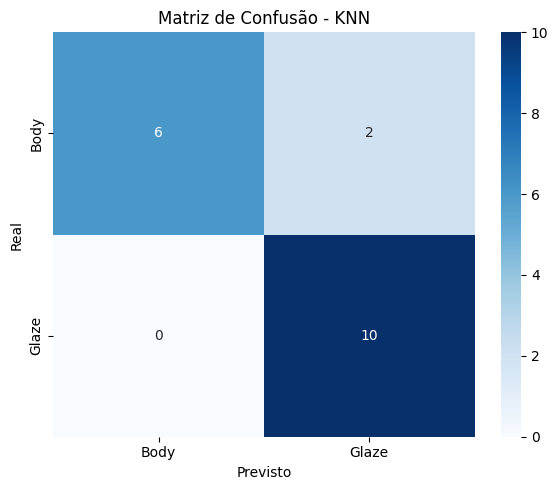

In [ ]:
# Plot da matriz de confusão
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
           xticklabels=['Body', 'Glaze'],
            yticklabels=['Body', 'Glaze'])

plt.title('Matriz de Confusão - KNN')
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.tight_layout()
plt.show()

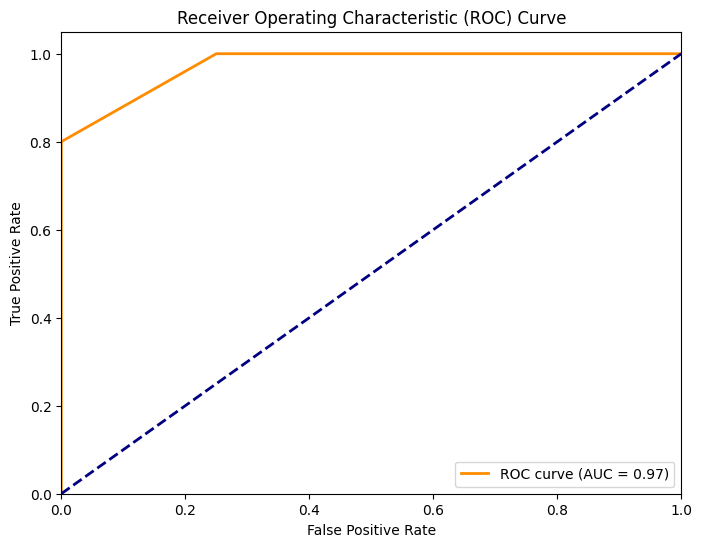

AUC: 0.9750


In [ ]:
# 3. Curva ROC e AUC
# Probabilidades preditas para a classe positiva (assumindo que y_test é binário)
y_prob = model_1.predict_proba(X_test_latent)[:, 1]

# Calcular fpr, tpr e thresholds para a curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plotar a Curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Exibir a AUC
print(f"AUC: {roc_auc:.4f}")

## Permutação

In [ ]:
# Treinar o modelo com os dados permutados
model_1.fit(X_train_latent, y_train_per)

# Fazer previsões no conjunto de teste
y_pred_permuted = model_1.predict(X_test_latent)

# Relatório de classificação detalhado
print("\nClassification Report:\n", classification_report(y_test, y_pred_permuted))


Classification Report:
               precision    recall  f1-score   support

         0.0       0.17      0.25      0.20         8
         1.0       0.00      0.00      0.00        10

    accuracy                           0.11        18
   macro avg       0.08      0.12      0.10        18
weighted avg       0.07      0.11      0.09        18



In [ ]:
# 1. Matriz de Confusão Random Forest Permutado
conf_matrix_per = confusion_matrix(y_test, y_pred_permuted)
print("Matriz de Confusão:")
print(conf_matrix_per)

Matriz de Confusão:
[[ 2  6]
 [10  0]]


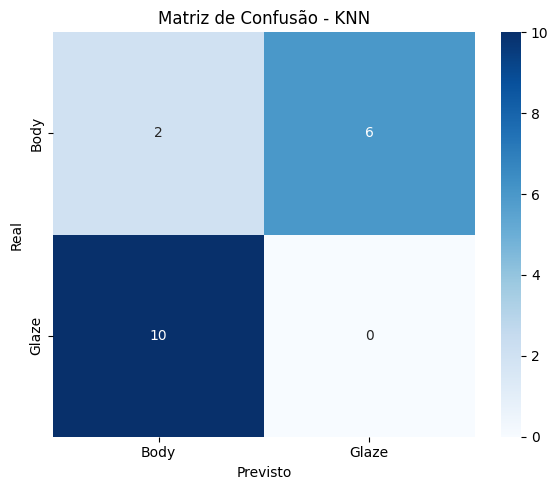

In [ ]:
# Plot da matriz de confusão
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_per, annot=True, fmt='d', cmap='Blues',
           xticklabels=['Body', 'Glaze'],
            yticklabels=['Body', 'Glaze'])

plt.title('Matriz de Confusão - KNN')
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.tight_layout()
plt.show()

In [ ]:
# Inverter as probabilidades preditas
y_prob_invertido = 1 - y_prob

# Recalcular a curva ROC
fpr_inv, tpr_inv, _ = roc_curve(y_test, y_prob_invertido)
roc_auc_inv = auc(fpr_inv, tpr_inv)

print(f"AUC invertido: {roc_auc_inv:.4f}")

AUC invertido: 0.0250
